In [1]:
import numpy as np
import tensorflow as tf
import pickle
import pickle
import pandas as pd

from random import randint
import datetime
from IPython.display import SVG
from IPython.display import HTML
from keras.utils.vis_utils import model_to_dot

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import norm

import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.merge import *
from keras.utils import to_categorical

from utils import *

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras import backend as K
from keras import metrics
%matplotlib inline

Using TensorFlow backend.


# MNIST EXPERIMENTS

In [2]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, 10))
inputs = Concatenate()([x,label])
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# zc = Concatenate()([z,label])
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model([x], y)
vae.compile(optimizer='adam', loss=None)


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit([x_train],
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test], x_test),
       callbacks=[EarlyStopping(patience=5)])

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

labels = to_categorical(y_test)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict([x_test], batch_size=batch_size)
fig = plt.figure(figsize=(15,7))
x = x_test_encoded[:, 0]
y = x_test_encoded[:, 1]
x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
sns.set_style("whitegrid")
plt.scatter(x=x, y=y, c=y_test, cmap='jet', s=50, edgecolors='black')
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
plt.colorbar()
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('MNIST_VAE.png', format='png', dpi=1000)

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [4]:
filename = 'data.pickle'
with open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
    data = pickle.load(f)
        
#Plot distribution of time across activity sorted by most popular
ts_np1 = data.app_cdf[:25]
x = np.arange(len(ts_np1))+1
sns.set_style("whitegrid")
df = pd.DataFrame.from_dict({'x' : x, 'y' : ts_np1})
fig = plt.figure(figsize=(15,10))
ax = sns.barplot(x='x', y='y', data=df)
plt.bar(x, ts_np1, alpha=1, color='blue')
plt.ylabel("% total time",fontsize = 20)
plt.xlabel("Most time-consuming categories",fontsize = 20)
plt.title("Cumulative percentage of time spent",fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.savefig('../images/time_spent.png', format='png', dpi=1000)

In [2]:
window_size = 6
time_percentage = 0.9
batch_size = 20
data_ = make_clean_data(window_size, batch_size,multiplier=1, process=False)

def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

/Users/asturkmani/Desktop/Thesis/utils.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['timestamp'] = pd.to_datetime(df['Date'])


(41178, 6, 1) (41178,) (41178, 6, 1) (41178,)


In [3]:
time_spent = data_['dataset'].sum(axis=0)/data_['dataset'].sum()*100

print("Dataset size:", data_['yc'].shape,'\n')
print("Number of apps that consume", time_percentage*100, "% of all users time: ",len(data_['popular_apps']), '\n')

Dataset size: (18280, 15) 

Number of apps that consume 90.0 % of all users time:  15 



# Visualising the data through PCA
Main components are:
    1. Video
    2. Software Development
    3. Instant Messaging & Social Networking

In [4]:
data_pca = PCA(n_components=2, whiten=True)
data_pca = data_pca.fit_transform(data_['yc'])

In [5]:
x = data_pca[:,0]
y = data_pca[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='PCA-Data')

# Visualizing using Variational Autoencoder
    1. PCA is limited in the information it can encode, i.e. 2D is very lossy. Also, it just shows the main modes of app usage.
    2. A VAE will represent the latent generative space which is more interesting as it allows us to know which apps are related as they will be encoded close to each other in this generative space. More structure is prevalent in the z space

In [6]:
m = 20 # batch size
n_z = 2 # latent space size
encoder_dim1 = 10 # dim of encoder hidden layer
decoder_dim = 10 # dim of decoder hidden layer
decoder_out_dim = len(data_['popular_apps']) # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.0005)


n_x = len(data_['popular_apps'])
# n_y = y_train.shape[1]


n_epoch = 100

In [7]:
X = Input(shape=(n_x,), name='Input')
# activity_regularizer = 'l2',
encoder_h = Dense(encoder_dim1, activation=activ,  name='Encoder_H')(X)
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='l_sigma')(encoder_h)


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])

decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name='Output')
h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return(K.sum(K.binary_crossentropy(y_pred, y_true), axis=1))

# build a model to project inputs on the latent space
vae = Model(X, outputs)
print(vae.summary())

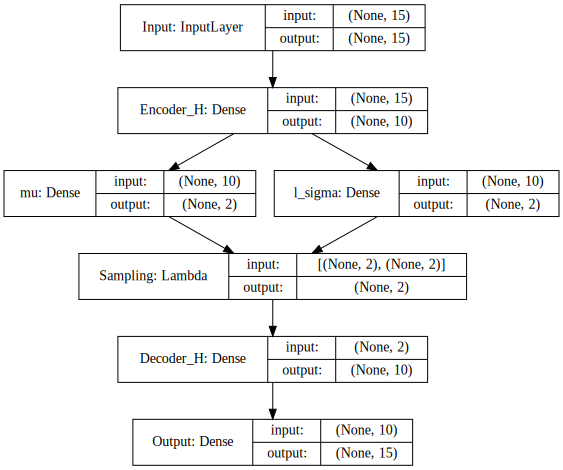

In [8]:
SVG(model_to_dot(vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [9]:
# Build Encoder and Generator models

# Generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(n_z,))
_h_decoded = decoder_hidden(decoder_input)
_x_decoded_mean = decoder_out(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

encoder = Model(X, mu)

In [10]:
vae.compile(optimizer=optim,
            loss=vae_loss,
            metrics = [KL_loss, recon_loss])

In [11]:
vae_hist = vae.fit(data_['y_train_c'], 
                   data_['y_train_c'],
                   verbose = 0,
                   shuffle=False,
                   batch_size=m,
                   epochs=n_epoch,
                   validation_data = (
                       data_['y_test_c'],
                       data_['y_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 5),
                       TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",
                                                              leave_outer=True,
                                                              leave_inner=True)]
                  )

### Viewing the latent space on entire dataset:

In [12]:
z_train = encoder.predict(data_['yc'])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['yc'].shape[0], n_z)
print(encodings.shape)

(18280, 2)


In [13]:
x = encodings[:,0]
y = encodings[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

# Conditional VAE

### Condition VAE on Time

In [36]:
m = 20 # batch size
n_z = 2 # latent space size
encoder_dim1 = 10 # dim of encoder hidden layer
decoder_dim = 10 # dim of decoder hidden layer
decoder_out_dim = len(data_['popular_apps']) # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.0005)


n_x = len(data_['popular_apps'])
n_y = data_['time']


n_epoch = 100

In [47]:
X = Input(shape=(n_x,), name='Input')
label = Input(shape=(n_y,), name='Time')
inputs = Concatenate()([X, label])

encoder_h = Dense(encoder_dim1, activation=activ, name='Encoder_H')(inputs)
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='l_sigma')(encoder_h)


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])
zc = Concatenate()([z, label])

decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name='Output')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return(K.sum(K.binary_crossentropy(y_pred, y_true), axis=1))

# build a model to project inputs on the latent space
c_t_vae = Model([X, label], outputs)
encoder_t = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder_t = Model(d_in, d_out)

print(c_t_vae.summary())

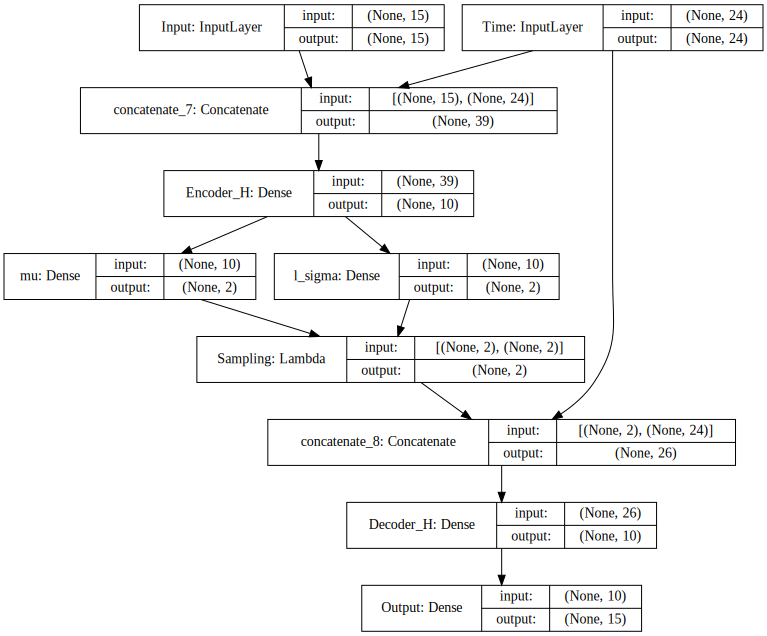

In [38]:
SVG(model_to_dot(cvae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [39]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [40]:
# compile and fit
cvae_hist = cvae.fit([data_['y_train_c'], to_categorical(data_['y_train_t'])], data_['y_train_c'], verbose = 0, batch_size=m, epochs=n_epoch,
                            validation_data = ([data_['y_test_c'], to_categorical(data_['y_test_t'])], data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",
                                                              leave_outer=True)])

In [41]:
z_train = encoder.predict([data_['yc'], to_categorical(data_['yt'])])
encodings_t= np.asarray(z_train)
encodings_t = encodings_t.reshape(data_['yc'].shape[0], n_z)
print(encodings_t.shape)

(18280, 2)


In [42]:
x = encodings_t[:,0]
y = encodings_t[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

### Condition VAE on Day

In [44]:
m = 20 # batch size
n_z = 2 # latent space size
encoder_dim1 = 10 # dim of encoder hidden layer
decoder_dim = 10 # dim of decoder hidden layer
decoder_out_dim = len(data_['popular_apps']) # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.0005)


n_x = len(data_['popular_apps'])
n_y = data_['days']


n_epoch = 100

In [49]:
X = Input(shape=(n_x,), name='Input')
label = Input(shape=(n_y,), name='Time')
inputs = Concatenate()([X, label])

encoder_h = Dense(encoder_dim1, activation=activ, name='Encoder_H')(inputs)
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='l_sigma')(encoder_h)


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])
zc = Concatenate()([z, label])

decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name='Output')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return(K.sum(K.binary_crossentropy(y_pred, y_true), axis=1))

# build a model to project inputs on the latent space
c_d_vae = Model([X, label], outputs)
encoder_d = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder_d = Model(d_in, d_out)

print(c_d_vae.summary())

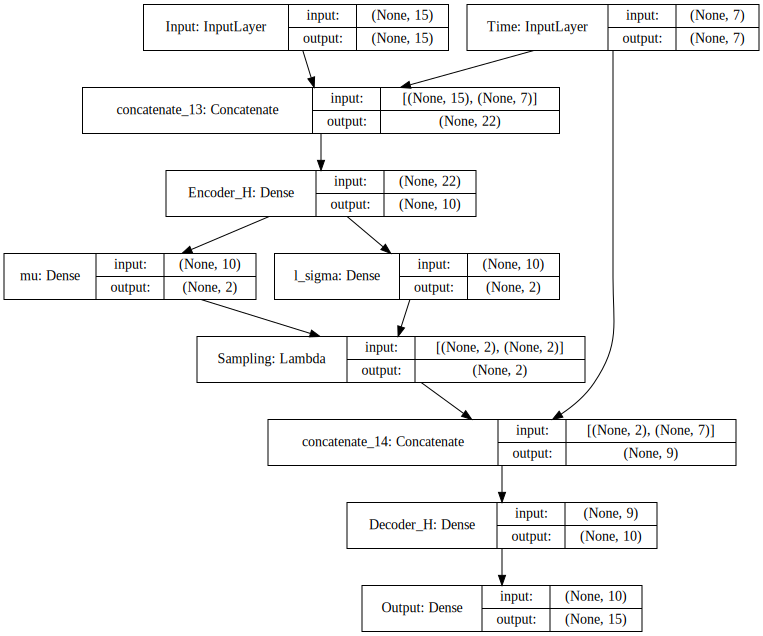

In [50]:
SVG(model_to_dot(c_d_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [52]:
# compile and fit
c_d_vae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])
c_d_vae_hist = c_d_vae.fit([data_['y_train_c'], to_categorical(data_['y_train_d'])], data_['y_train_c'], verbose = 0, batch_size=m, epochs=n_epoch,
                            validation_data = ([data_['y_test_c'], to_categorical(data_['y_test_d'])], data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",
                                                              leave_outer=True)])

In [58]:
z_train = encoder_d.predict([data_['yc'], to_categorical(data_['yd'])])
encodings_d = np.asarray(z_train)
encodings_d = encodings_d.reshape(data_['yc'].shape[0], n_z)
print(encodings_d.shape)

(18280, 2)


In [59]:
x = encodings_d[:,0]
y = encodings_d[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='C_d_VAE-Data')

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

### Condition VAE on Time and Day

In [19]:
m = 20 # batch size
n_z = 2 # latent space size
encoder_dim1 = 8 # dim of encoder hidden layer
decoder_dim = 8 # dim of decoder hidden layer
decoder_out_dim = len(data_['popular_apps']) # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.0005)


n_x = len(data_['popular_apps'])
n_d = data_['days']
n_t = data_['time']


n_epoch = 100

In [20]:
X = Input(shape=(n_x,), name='Input')
day = Input(shape=(n_d,), name='Day')
time = Input(shape=(n_t,), name='Time')
inputs = Concatenate()([X, day, time])

encoder_h = Dense(encoder_dim1, activation=activ, name='Encoder_H')(inputs)
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='l_sigma')(encoder_h)


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])
zc = Concatenate()([z, day, time])

decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name='Output')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return(K.sum(K.binary_crossentropy(y_pred, y_true), axis=1))

# build a model to project inputs on the latent space
c_dt_vae = Model([X, day, time], outputs)
encoder_dt = Model([X, day, time], mu)

d_in = Input(shape=(n_z+n_t+n_d,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder_dt = Model(d_in, d_out)

print(c_dt_vae.summary())

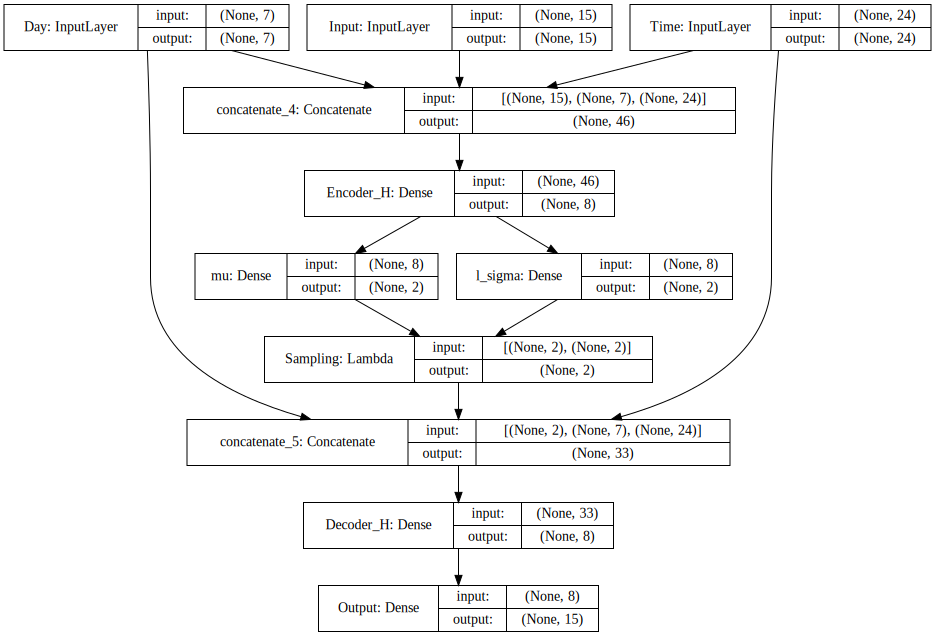

In [21]:
SVG(model_to_dot(c_dt_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [22]:
# compile and fit
c_dt_vae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])
c_dt_vae_hist = c_dt_vae.fit([data_['y_train_c'], 
                             to_categorical(data_['y_train_d']), 
                             to_categorical(data_['y_train_t'])], 
                            data_['y_train_c'], 
                            verbose = 0, 
                            batch_size=m, 
                            epochs=n_epoch,
                            validation_data = (
                                [data_['y_test_c'], 
                                 to_categorical(data_['y_test_d']),
                                 to_categorical(data_['y_test_t'])], 
                                data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",
                                                              leave_outer=True)])

In [23]:
z_train = encoder_dt.predict([data_['yc'], to_categorical(data_['yd']), to_categorical(data_['yt'])])
encodings_dt = np.asarray(z_train)
encodings_dt = encodings_dt.reshape(data_['yc'].shape[0], n_z)
print(encodings_dt.shape)

(18280, 2)


In [24]:
x = encodings_dt[:,0]
y = encodings_dt[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='C_d_VAE-Data')

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

## Analysis of VAE latent spaces
    1. VAE: The model tries to find a latent space that clusters the data well as that is the most important information required to reconstruct the data points
    2. VAE with time/day: we observe that the model drifts away from models with sharp modal properties and moves towards more gaussian shapes - this indicates the model benefits from the information in time/day conditionals which allow reconstruction to happen with drifting too much away from the standard normal prior.
    3. VAE with time & day: here we observe the model moves attains a fairly acc

In [49]:
def construct_numvec(t,d, z = None):
    out = np.zeros((1, n_z + n_d + n_t))
    out[:, d + n_z] = 1.
    out[:, 7 + n_z + t] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)

In [50]:
d = list()
for day in range(7):
    t = list()
    for time in range(24):
        t.append(decoder_dt.predict(construct_numvec(time, day)))
    d.append(t)
d = np.asarray(d).reshape((7,24,15))
d_colors = list()
for day in d:
    d_colors.append(np.einsum('ij,jk->ik', day, data_['cmap']))
d_colors = np.asarray(d_colors)*256

## What the average week looks like

/home/asturkmani/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



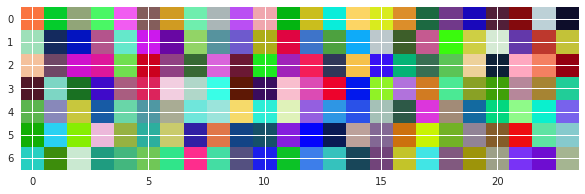

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(d_colors)
plt.show()

## What a Monday afternoon could look like

In [85]:
day = 1
time = 12
sides = 8
max_z = 1

img_it = 0
imz = np.zeros((8,8,3))
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(12, 1, z_)
        decoded = decoder_dt.predict(vec)
        decoded = np.einsum('ij,jk->ik', decoded, data_['cmap'])
        img_it +=1
        imz[i,j,:] = decoded
imz = np.asarray(imz)

/home/asturkmani/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



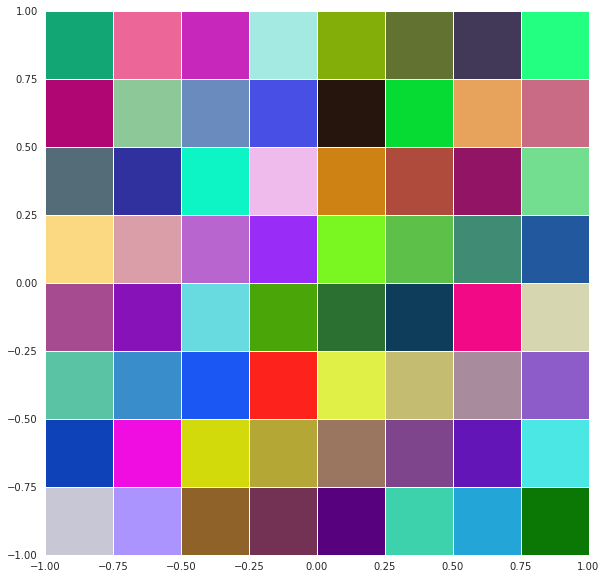

In [86]:
plt.figure(figsize=(10, 10))
plt.imshow(imz, extent=[-max_z,max_z,-max_z,max_z])
plt.show()

# Analysis:
    1. While more structure certainly exists with this encoding, it clearly is not enough and simply using static point in time samples doesn't convey embedded structure. Statics points lack temporal information which is essential in modeling and understanding app-usage behaviour. Next, we train an LSTM and encode the hidden state to explore whether that includes more/better information
